In [1]:
import numpy as np
import osmnx as ox

from orderbike import metrics
from utg import create_graph, utils

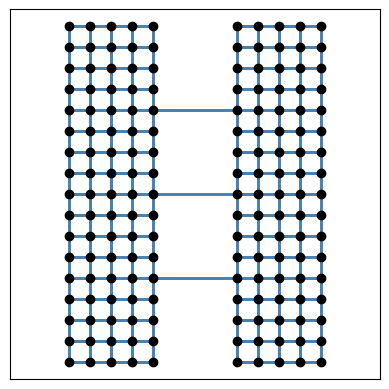

In [2]:
G = create_graph.create_bridge_graph(outrows=4, sscols=5, bridges=3, blength=200)
G = utils.make_osmnx_compatible(G)
utils.plot_graph(G)

In [3]:
print(len(G), len(G.edges))

170 598


In [4]:
orig = 0
dest = 85
print(G.nodes[orig], G.nodes[dest])

{'x': 0, 'y': 0} {'x': 400, 'y': 0}


In [5]:
route = ox.routing.shortest_path(G, orig, dest, weight="length")
route

[0, 17, 34, 51, 68, 69, 70, 71, 72, 89, 88, 87, 86, 85]

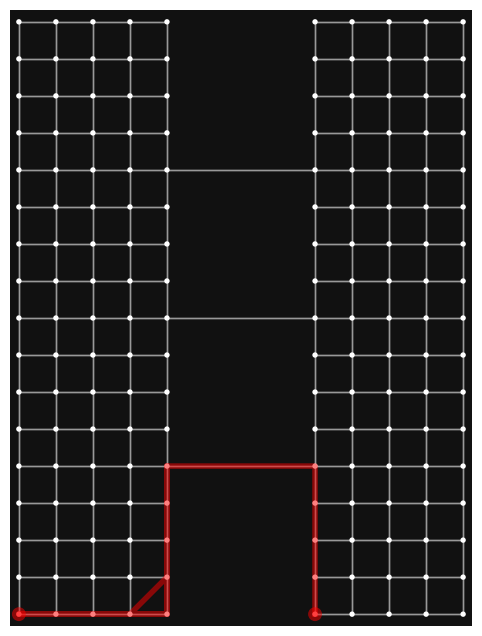

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
ox.plot_graph_route(G, route)

In [7]:
sm = metrics.get_shortest_network_path_matrix(G)
sm[orig][dest]

800.0

In [8]:
em = metrics.get_euclidean_distance_matrix(G, lonlat=False)
em[orig][dest]

400.0

In [9]:
dm = metrics.get_directness_matrix(G, lonlat=False)
dm[orig][dest]

0.5

In [10]:
metrics.directness_from_matrix(dm)

0.7900126449020083

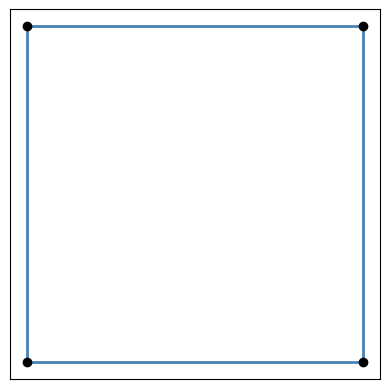

In [11]:
G = create_graph.create_grid_graph(cols=2, rows=2)
utils.plot_graph(G)

In [12]:
metrics.directness_from_matrix(metrics.get_directness_matrix(G, lonlat=False))

0.9023689270621825

In [14]:
(4 + np.sqrt(2)) / 6

0.9023689270621825